In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from numpy import genfromtxt
import numpy as np
import time
import random
import math
from scipy.optimize import minimize

In [2]:
# load (downloaded if needed) the MNIST dataset

train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

#y_train = np.array(df['label'].values)
#print(y_train)

X_train = (train.iloc[:,1:].values.astype('float32'))
y_train = (train.iloc[:,0].values.astype('int32'))
y_train = np.tile(y_train, (1, 1))
X_test = test.values.astype('float32')

In [3]:
print(X_train.shape[1])

784


In [45]:
class Neural_Network:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.m = X_train.shape[0]
        self.input_layer_size = X_train.shape[1]
        self.hidden_layer_size = 25
        self.output_layer_size = 10
        self.epsilon = []
        self.theta1 = 0
        self.theta2 = 0
        self.J = 0
        self.grad = 0
        self.num_labels = 10
        self.grad = 0
        self.counter = 0
        
    def randInit(self, X, y):
        ils = self.input_layer_size
        hls = self.hidden_layer_size
        ols = self.output_layer_size
        
        L_in = ils
        L_out = hls
        
        self.epsilon.append(math.sqrt(6) / math.sqrt(L_in + L_out))
        
        L_in = hls
        L_out = ols
        
        self.epsilon.append(math.sqrt(6) / math.sqrt(L_in + L_out))
        
        #The theta values are of the form S(j + 1) x S(j) + 1 where S(j) i sthe size of the layer at j
        
        self.theta1 = np.dot(np.random.rand(hls, ils + 1), (2 * self.epsilon[0])) - self.epsilon[0]
        
        self.theta2 = np.dot(np.random.rand(ols, hls + 1), (2 * self.epsilon[1])) - self.epsilon[1]
        
    def sigmoid(self, z):
        return ( 1/(1 + np.exp(-z)))
    
    def sigmoidPrime(self, z):
        z = self.sigmoid(z)
        return np.multiply(z, (1-z))
    
    def costFunction(self, nn_params, ils, hls, num_labels, X, y, lam):
        y = y.T
        self.counter+=1
        
        theta1 = np.reshape(nn_params[:hls * (ils + 1)], \
                     (hls, ils + 1), order='F')
        
        theta2 = np.reshape(nn_params[hls * (ils + 1):], \
                     (num_labels, hls + 1), order='F')
        
        #Foward propogation
        a1 = np.hstack((np.ones((self.m, 1)), X ))
        
        z2 = np.dot(a1, theta1.T)
        
        a2 = self.sigmoid(z2)
        a2 = np.hstack((np.ones((a2.shape[0], 1)), a2))
        
        z3 = np.dot(a2, theta2.T)
        
        a3 = self.sigmoid(z3)
        
        #Cost function
        
        numLabels_temp = np.tile([i for i in range(10)], (self.m, 1))
        
        yMatrix_temp = np.tile(y.T[:], (1,self.num_labels) )
        
        yMatrix = np.equal(numLabels_temp, yMatrix_temp)
        
        cost_no_reg = np.sum(np.multiply(yMatrix, np.log(a3)) + np.multiply((1-yMatrix), np.log(1 - a3)))
        
        reg = (lam / (2*self.m)) * ((np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:])))) ** 2
        
        self.J =  ((-1/self.m) * cost_no_reg) + reg
        
        self.grad = self.backProp(theta1, theta2)
        
        print(self.counter, ") Cost: ", self.J)
        
        return self.J, self.grad
        
    def backProp(self, theta1, theta2):
        X = self.X_train
        y = self.y_train
        y = y.T
        lam = 0
        
        numLabels_temp = np.tile([i for i in range(10)], (self.m, 1) )
        
        yMatrix_temp = np.tile(y[:], (1,self.num_labels) )
        
        yMatrix = np.equal(numLabels_temp, yMatrix_temp)
        
        delta2 = 0
        delta1 = 0
        
        for i in range(0, self.m):
            
            a1 = np.append(1, X[i, :] )
            a1 = a1.reshape(1, a1.size)
        
            z2 = np.dot(a1, theta1.T)

            a2 = self.sigmoid(z2)
            a2 = np.append(1, a2)
            a2 = a2.reshape(1, a2.size)

            z3 = np.dot(a2, theta2.T)

            a3 = self.sigmoid(z3)
            a3 = a3.reshape(1, a3.size)
            
            yMatrix_i = yMatrix[i, :]
            yMatrix_i.reshape(1, yMatrix_i.size)
            
            delta3_i = np.subtract(a3, yMatrix_i)
            
            g2 = self.sigmoidPrime(np.insert(z2, 0, 1, axis=1))
            g2 = g2.reshape(1, g2.size)
            
            delta2_i = np.multiply(np.dot(theta2.T, delta3_i.T), g2.T)
            delta2_i = delta2_i[1:].T
            
            delta2 = delta2 + np.dot(delta3_i.T, a2)
            
            delta1 = delta1 + np.dot(delta2_i.T, a1)
            
        #theta1_no_bias = np.multiply((lam/self.m), theta1[:, 1:])
        #theta2_no_bias = np.multiply((lam/self.m), theta2[:, 1:])
        
        #theta1_bias = np.multiply((1/self.m), delta1[:, 1])
        #theta1_bias = theta1_bias.reshape(theta1_bias.size, 1)
        
        #theta2_bias = np.multiply((1/self.m), delta2[:, 1])
        #theta2_bias = theta2_bias.reshape(theta2_bias.size, 1)
        
        #Theta1_grad = np.concatenate((theta1_bias, np.add(np.multiply((1/self.m), delta1[:, 1:]), theta1_no_bias)), axis=1)
        #Theta2_grad = np.concatenate((theta2_bias, np.add(np.multiply((1/self.m), delta2[:, 1:]), theta2_no_bias)), axis=1)
        
        #self.grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), Theta2_grad.reshape(Theta2_grad.size, order='F')))
        
        Theta1_grad = delta1 / self.m
        Theta2_grad = delta2 / self.m
        
        Theta1_grad_unregularized = np.copy(Theta1_grad)
        Theta2_grad_unregularized = np.copy(Theta2_grad)
        Theta1_grad += (float(lam)/self.m)*theta1
        Theta2_grad += (float(lam)/self.m)*theta2
        Theta1_grad[:,0] = Theta1_grad_unregularized[:,0]
        Theta2_grad[:,0] = Theta2_grad_unregularized[:,0]
        
        self.grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), Theta2_grad.reshape(Theta2_grad.size, order='F')))
        
        return self.grad
        
    def train(self, theta1, theta2, nn_params, X, y):
        
        print(self.J,)
        print('Training Neural Network...')
        maxiter = 20
        #maxiter = 30
        #maxiter = 100
        #maxiter = 5
        
        lambda_reg = 0.1
        
        nn_params = np.concatenate((theta1.reshape(theta1.size, order='F'), theta2.reshape(theta2.size, order='F')))
        
        myargs = (self.input_layer_size, self.hidden_layer_size, self.num_labels, X, y, lambda_reg)
        results = minimize(self.costFunction, x0=nn_params, args=myargs, options={'disp': True, 'maxiter':maxiter}, method="L-BFGS-B", jac=True)

        nn_params = results["x"]

        # Obtain Theta1 and Theta2 back from nn_params
        Theta1 = np.reshape(nn_params[:self.hidden_layer_size * (self.input_layer_size + 1)], \
                         (self.hidden_layer_size, self.input_layer_size + 1), order='F')

        Theta2 = np.reshape(nn_params[self.hidden_layer_size * (self.input_layer_size + 1):], \
                         (self.num_labels, self.hidden_layer_size + 1), order='F')

        print('Program paused. Press enter to continue.\n')
        return Theta1,Theta2
    
    def predict(self, Theta1, Theta2, X):
        #Description
        
        # turns 1D X array into 2D
        if X.ndim == 1:
            X = np.reshape(X, (-1,X.shape[0]))

        # Useful values
        m = X.shape[0]
        num_labels = Theta2.shape[0]

        # You need to return the following variables correctly 
        p = np.zeros((m,1))

        h1 = self.sigmoid( np.dot( np.column_stack( ( np.ones((m,1)), X ) ) , Theta1.T ) )
        h2 = self.sigmoid( np.dot( np.column_stack( ( np.ones((m,1)), h1) ) , Theta2.T ) )

        p = np.argmax(h2, axis=1)

        # =========================================================================

        return p + 1# offsets python's zero notation

In [46]:
y = y_train
y = y.T

print(y[:].shape)

(42000, 1)


In [ ]:
nn = Neural_Network(X_train, y_train)
nn.randInit(X_train, y_train)
nn_params = np.concatenate((nn.theta1.reshape(nn.theta1.size, order='F'), nn.theta2.reshape(nn.theta2.size, order='F')))
theta1, theta2 = nn.train(nn.theta1, nn.theta2, nn_params, X_train, y_train.T)

pred = nn.predict(theta1, theta2, X_train)

0
Training Neural Network...
[[1 0 1 ... 7 6 9]]

1 ) Cost:  7.437345671729642
[[1 0 1 ... 7 6 9]]


In [32]:
k = 0
print(pred[k])
for i in pred:
    if(i == 10):
        pred[k] = 0
    k+=1
print('Training Set Accuracy: {:f}'.format( ( np.mean(pred == y_train)*100 ) ) )

[2 2 2 ... 2 2 2]
Training Set Accuracy: 9.945238


In [22]:
ans = nn.predict(theta1,theta2, X_test)
print(ans.shape)
print(type(ans))

(28000,)
<class 'numpy.ndarray'>


In [23]:
k = 0
print(ans[1])
for i in ans:
    if(i == 10):
        ans[k] = 0
    k+=1
print(ans[1])

2
2


In [24]:
df = pd.DataFrame(data=ans,columns=["Label"])
file = "submission0.csv"
df.reset_index(level=0, inplace=True)
#df['ImageId'] = df.index
df.columns = ['ImageId', 'Label']
for i in df['ImageId']:
    df['ImageId'][i]+=1
#for
print(df[:5])
df.to_csv(file, index=False)

   ImageId  Label
0        1      2
1        2      2
2        3      2
3        4      2
4        5      2


2


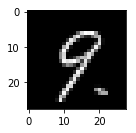

In [31]:
digit = X_test.reshape(X_test.shape[0],28,28)
print(ans[0])
plt.subplot(221)
plt.imshow(digit[i], cmap=plt.get_cmap('gray'))